# Tissue Detection and Patch Extraction from IDC Slides

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/02_tissue_masking_and_patch_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

Before running any analysis on a whole slide image, we typically need to:
1. **Detect tissue regions** to avoid processing the empty glass background
2. **Extract patches** from those tissue regions for downstream analysis

This notebook demonstrates how to:
- Use TIAToolbox's tissue masking (Otsu-based) to identify tissue regions
- Extract patches from tissue regions using `SlidingWindowPatchExtractor`
- Visualize extracted patches and their locations on the slide

**No GPU required** for this notebook.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [ ]:
%%capture
%pip install "tiatoolbox==1.6.0" idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.tools.tissuemask import OtsuTissueMasker
from tiatoolbox.tools.patchextraction import SlidingWindowPatchExtractor

  check_for_updates()



## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [2]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 16:21:47 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 10.8 GB available
GPU:  Not available


## 1. Select and Download an IDC Slide

In [3]:
idc_client = IDCClient()
idc_client.fetch_index("sm_index")

# Find a small 20x slide from CPTAC-LUAD
candidates = idc_client.sql_query("""
    SELECT
        i.SeriesInstanceUID,
        i.PatientID,
        ROUND(i.series_size_MB, 1) as size_mb,
        s.ObjectiveLensPower,
        s.max_TotalPixelMatrixColumns as width,
        s.max_TotalPixelMatrixRows as height,
        s.min_PixelSpacing_2sf as pixel_spacing_mm
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    WHERE i.collection_id = 'cptac_luad'
        AND s.ObjectiveLensPower = 20
    ORDER BY i.series_size_MB ASC
    LIMIT 5
""")

selected = candidates.iloc[0]
series_uid = selected['SeriesInstanceUID']
print(f"Selected: {selected['PatientID']}, {selected['size_mb']} MB, {selected['width']}x{selected['height']} @ {selected['ObjectiveLensPower']}x")

Selected: C3L-03262, 21.8 MB, 9959x9023 @ 20x


In [4]:
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[series_uid],
    dirTemplate='%SeriesInstanceUID'
)

slide_path = os.path.join(download_dir, series_uid)
reader = WSIReader.open(slide_path)

# DICOMWSIReader may not populate objective_power or mpp from DICOM metadata
info = reader.info
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
if info.mpp is None:
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])

print(f"Opened: {type(reader).__name__}, dimensions: {info.slide_dimensions}")

Opened: DICOMWSIReader, dimensions: (9959, 9023)


## 2. Tissue Masking

TIAToolbox provides tissue masking methods to separate tissue from the glass background. The most common approach is **Otsu's thresholding**, which automatically finds the optimal threshold to separate foreground (tissue) from background (glass).

### Using OtsuTissueMasker directly

In [5]:
# Generate a thumbnail for masking
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
print(f"Thumbnail shape: {thumbnail.shape}")

# Apply Otsu tissue masking
masker = OtsuTissueMasker()
tissue_mask = masker.fit_transform([thumbnail])[0]

print(f"Mask shape: {tissue_mask.shape}")
print(f"Tissue coverage: {tissue_mask.mean() * 100:.1f}%")

Thumbnail shape: (564, 622, 3)
Mask shape: (564, 622)
Tissue coverage: 12.9%


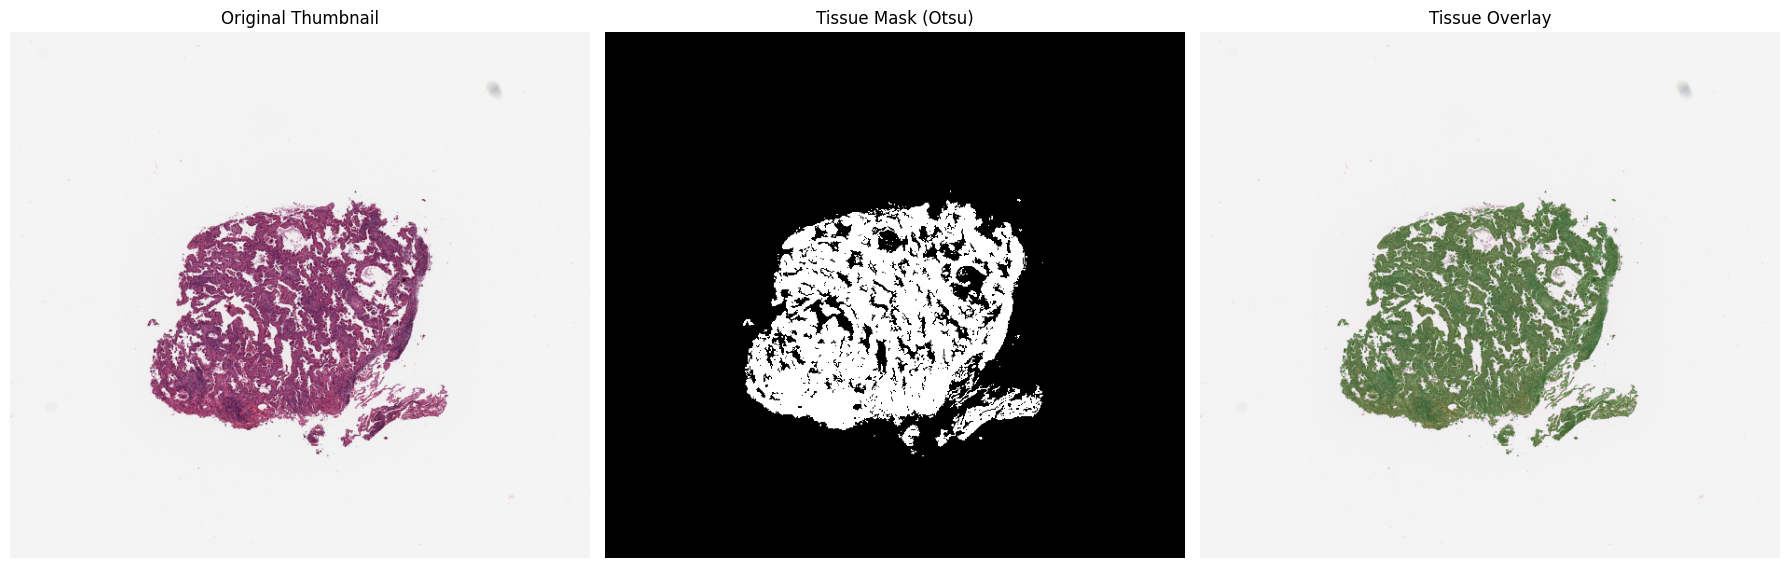

In [6]:
# Visualize the tissue mask
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(thumbnail)
axes[0].set_title("Original Thumbnail", fontsize=12)
axes[0].axis('off')

axes[1].imshow(tissue_mask, cmap='gray')
axes[1].set_title("Tissue Mask (Otsu)", fontsize=12)
axes[1].axis('off')

# Overlay mask on thumbnail
overlay = thumbnail.copy()
mask_rgb = np.zeros_like(thumbnail)
mask_rgb[tissue_mask > 0] = [0, 255, 0]  # Green for tissue
overlay = np.where(tissue_mask[..., None] > 0,
                   (0.7 * thumbnail + 0.3 * mask_rgb).astype(np.uint8),
                   thumbnail)

axes[2].imshow(overlay)
axes[2].set_title("Tissue Overlay", fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## 3. Patch Extraction

TIAToolbox's `SlidingWindowPatchExtractor` extracts patches from a WSI using a sliding window approach. Combined with tissue masking, it only extracts patches from tissue regions.

Key parameters:
- **`patch_size`**: Size of each patch in pixels
- **`stride`**: Step size between patches (same as patch_size for non-overlapping)
- **`resolution` / `units`**: Resolution at which to extract patches
- **`input_mask`**: Use `"otsu"` to automatically mask to tissue regions
- **`min_mask_ratio`**: Minimum fraction of the patch that must be tissue (0-1)

In [7]:
# Extract non-overlapping 512x512 patches at native resolution
# Only from tissue regions (at least 50% tissue)
extractor = SlidingWindowPatchExtractor(
    input_img=reader,
    patch_size=(512, 512),
    stride=(512, 512),
    input_mask="otsu",
    min_mask_ratio=0.5,
    resolution=info.objective_power,
    units="power",
)

# Collect patches (limit to first 100 for demo)
patches = []
coords = []
max_patches = 100

for i, patch in enumerate(extractor):
    patches.append(patch)
    coords.append(extractor.coordinate_list[i])
    if i + 1 >= max_patches:
        break

total_available = len(extractor.coordinate_list)
print(f"Total tissue patches available: {total_available}")
print(f"Collected: {len(patches)} patches")
print(f"Patch shape: {patches[0].shape}")

Total tissue patches available: 50
Collected: 50 patches
Patch shape: (512, 512, 3)


### Visualize Extracted Patches

Let's look at a grid of the extracted tissue patches.

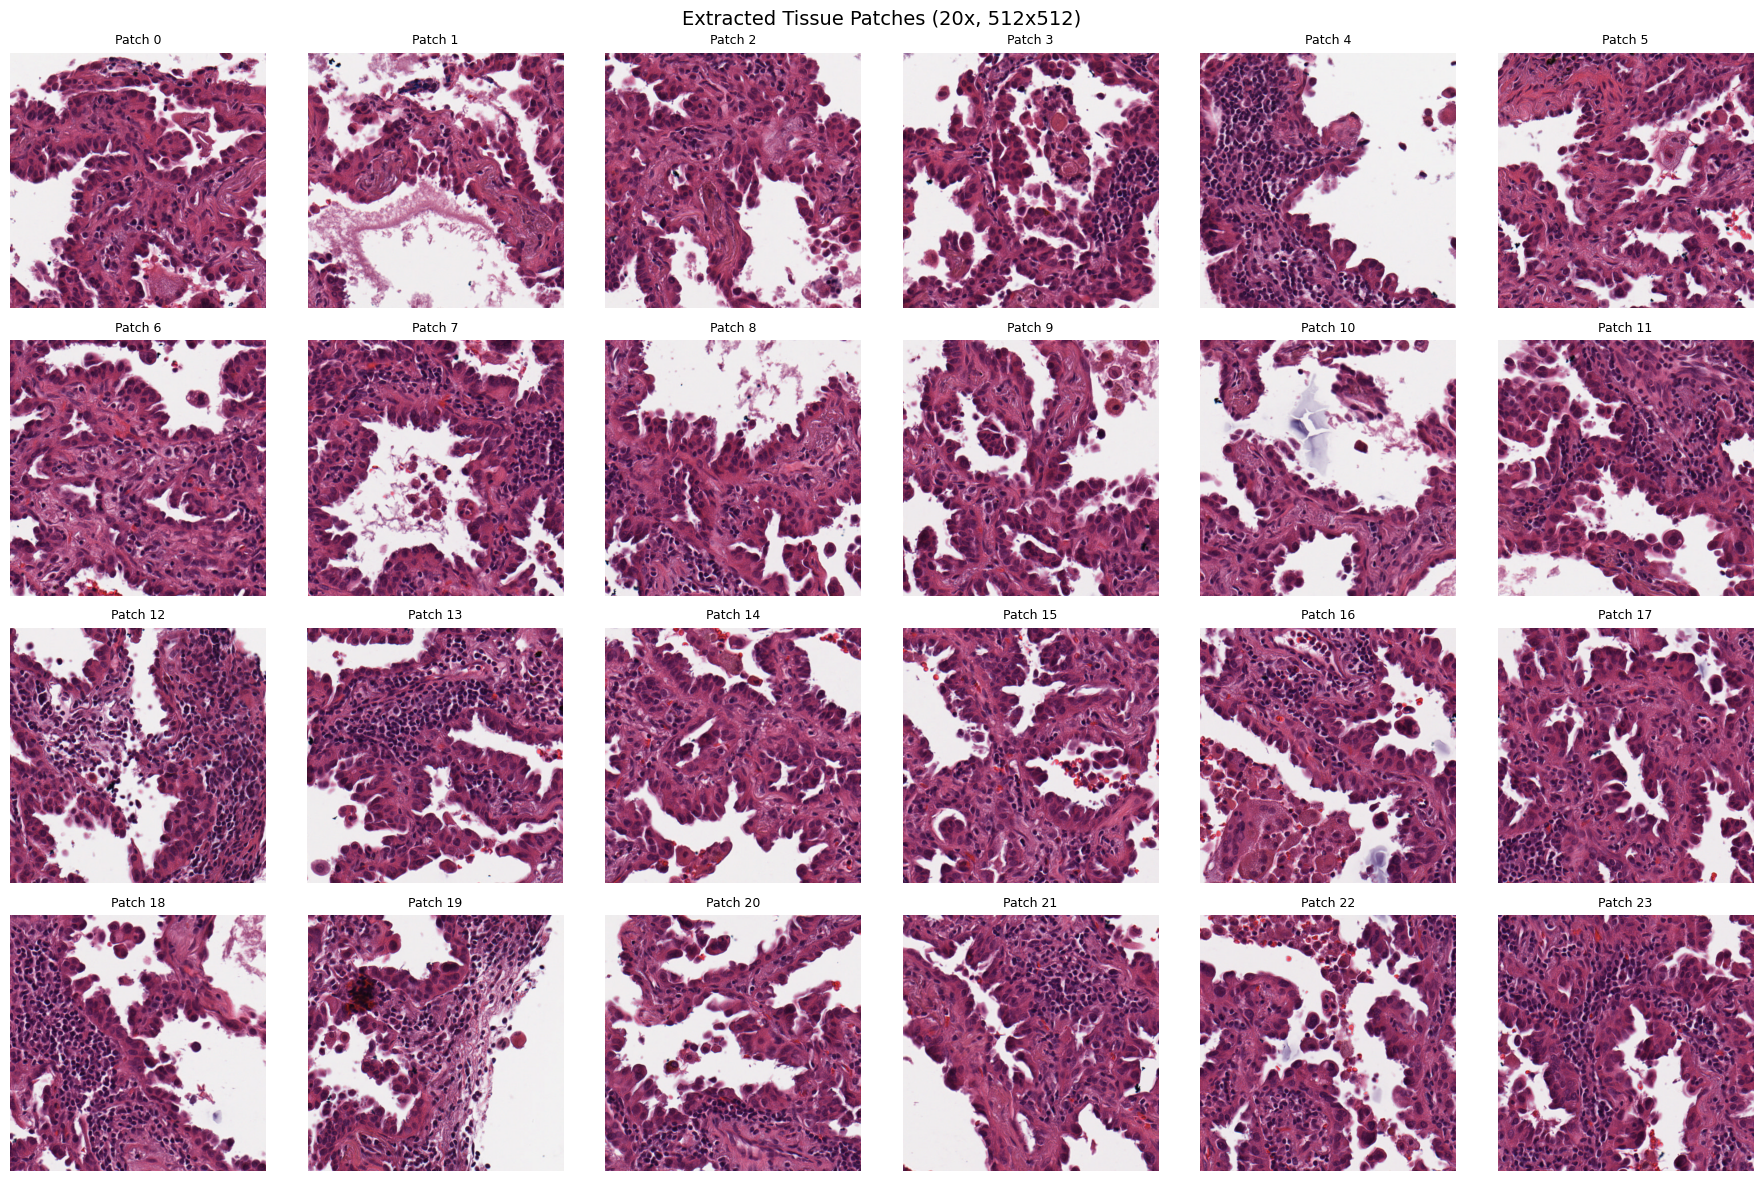

In [8]:
# Display a 4x6 grid of patches
n_rows, n_cols = 4, 6
n_display = min(n_rows * n_cols, len(patches))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
for i in range(n_rows * n_cols):
    ax = axes[i // n_cols][i % n_cols]
    if i < n_display:
        ax.imshow(patches[i])
        ax.set_title(f"Patch {i}", fontsize=9)
    ax.axis('off')

native = int(info.objective_power)
plt.suptitle(f"Extracted Tissue Patches ({native}x, 512x512)", fontsize=14)
plt.tight_layout()
plt.show()

### Visualize Patch Locations on the Slide

Let's overlay the locations of the extracted patches on the slide thumbnail to see which areas they came from.

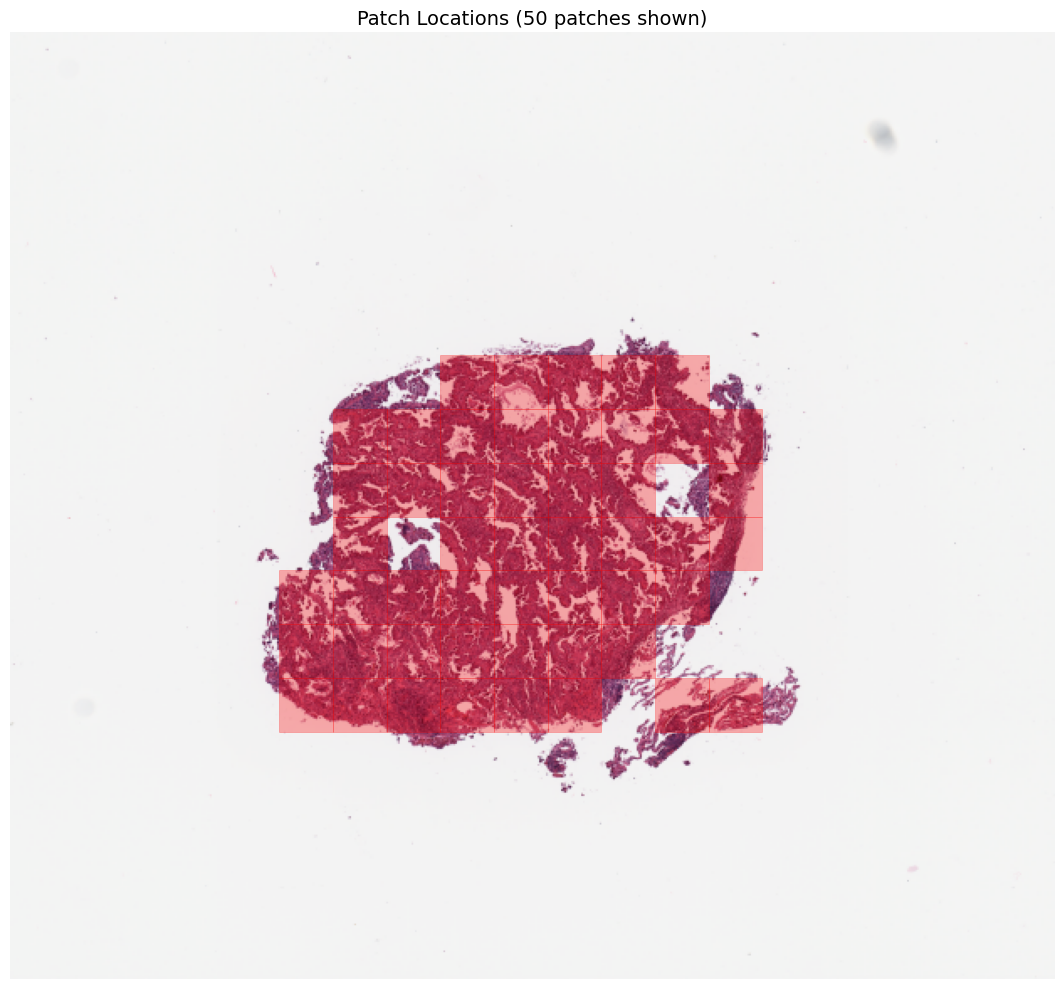

In [9]:
# Plot patch locations on the thumbnail
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(thumbnail)

# Scale coordinates from extraction resolution to thumbnail
slide_w, slide_h = reader.info.slide_dimensions
thumb_h, thumb_w = thumbnail.shape[:2]
scale_x = thumb_w / slide_w
scale_y = thumb_h / slide_h

# The coordinate_list contains (x_start, y_start, x_end, y_end) in baseline coords
for coord in coords:
    x_start, y_start, x_end, y_end = coord
    rect = mpatches.Rectangle(
        (x_start * scale_x, y_start * scale_y),
        (x_end - x_start) * scale_x,
        (y_end - y_start) * scale_y,
        linewidth=0.5, edgecolor='red', facecolor='red', alpha=0.3
    )
    ax.add_patch(rect)

ax.set_title(f"Patch Locations ({len(coords)} patches shown)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Exploring Different Extraction Parameters

Let's see how different resolution and stride settings affect patch extraction.

In [10]:
# Compare patch counts at different resolutions
# Note: DICOMWSIReader has a coordinate bug at resolutions mapping to
# non-baseline pyramid levels. We use native resolution which is reliable.
native = int(info.objective_power)
ext = SlidingWindowPatchExtractor(
    input_img=reader,
    patch_size=(256, 256),
    stride=(256, 256),
    input_mask="otsu",
    min_mask_ratio=0.5,
    resolution=info.objective_power,
    units="power",
)
n_native = len(ext.coordinate_list)
print(f"Tissue patches at {native}x (256x256, non-overlapping): {n_native}")

# At different magnifications the number of patches scales quadratically:
# halving the magnification gives ~1/4 the patches
print(f"\nExpected scaling (relative to {native}x):")
for power in [5, 10, 20, 40]:
    scale = (power / info.objective_power) ** 2
    est = int(n_native * scale)
    print(f"  {power}x: ~{est} patches (scale factor {scale:.2f})")

Tissue patches at 20x (256x256, non-overlapping): 194

Expected scaling (relative to 20x):
  5x: ~12 patches (scale factor 0.06)
  10x: ~48 patches (scale factor 0.25)
  20x: ~194 patches (scale factor 1.00)
  40x: ~776 patches (scale factor 4.00)


## Summary

In this notebook, we learned how to:

- Apply **Otsu tissue masking** to detect tissue regions and avoid processing glass background
- Use `SlidingWindowPatchExtractor` to extract patches from tissue-only areas
- Control patch extraction with parameters like `patch_size`, `stride`, `resolution`, and `min_mask_ratio`
- Visualize extracted patches and their spatial locations on the slide
- Understand how resolution affects the number of patches extracted

**Next:** [Notebook 03](03_stain_normalization.ipynb) covers stain normalization to handle color variation across different slides and scanners.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5